In [23]:
import itertools

import numpy as np
import pandas as pd
import altair as alt
import altair_catplot as altcat

import bebi103

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
color_palette=['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

Loading BokehJS ...

In [24]:
cd ~/git/BE-Bi-103/Codes/HW8

/Users/Sanyo 1/git/BE-Bi-103/Codes/HW8


In [25]:
df = pd.read_csv('shao_et_al_wst-1_assay.csv')

In [26]:
df.head()

,Treatment,Experiment,assay_result
0,Control,One,1.45945
1,Control,One,1.51035
2,Control,One,1.80045
3,Control,One,1.83745
4,PLA_1,One,1.42015


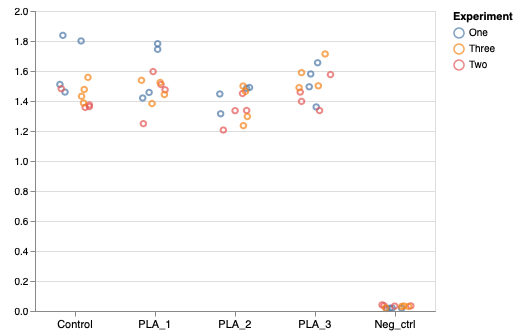

In [27]:
altcat.catplot(data=df,
               mark='point',
               encoding=dict(y=alt.Y('assay_result:Q', title=None),
                             x='Treatment:N', 
                             color=alt.Color('Experiment:N')),
               transform='jitter'
              )

In [28]:
model_code_pri_pred = """
data {
  // Total number of data points
  int N;
  int J_1;
  real hyper_theta_mu;
  real hyper_theta_sigma;
  real hyper_sigma;
  real hyper_tau;
}


generated quantities {
  real n[N * J_1];
  real theta = normal_rng(hyper_theta_mu, hyper_theta_sigma);
  real sigma = fabs(normal_rng(0, hyper_sigma));
  real tau = fabs(normal_rng(0, hyper_tau));
  real theta_1[J_1];  
  
  for (i in 1:J_1) {
    theta_1[i] = normal_rng(theta, sigma);
    for (j in 1:N) {
      n[(i - 1) * N + j] = normal_rng(theta_1[i], tau);
    }
  }
    
  }
"""

In [29]:
# Complie from the standalone file
sm_gen = bebi103.stan.StanModel(model_code=model_code_pri_pred)

Using cached StanModel.


In [30]:
N_iter = 1000

data = dict(N=4,
            J_1=3,
            hyper_theta_mu=1.,
            hyper_theta_sigma=0.3,
            hyper_sigma=0.1,
            hyper_tau=0.1)

df_pred = sm_gen.sampling(data=data,
                     algorithm='Fixed_param',
                     warmup=0,
                     chains=1,
                     iter=N_iter)

df_samples = bebi103.stan.extract_array(df_pred, name='n')

bokeh.io.show(
    bebi103.viz.predictive_ecdf(df_pred, 
                                'n', 
                                x_axis_label='WT, number of reversals'))

In [31]:
num_neg, _ = df_samples.loc[df_samples['n'] < 0].shape

num_neg / N_iter

0.032

In [56]:
model_code_centered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1;
}


model {
  theta ~ normal(1, 0.3);
  sigma ~ normal(0, 0.1);
  tau ~ normal(0, 0.1);

  theta_1 ~ normal(theta, tau);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

In [57]:
data, df_part = bebi103.stan.df_to_datadict_hier(df.loc[df['Treatment']=='Control'],
                                           level_cols=['Experiment'],
                                           data_cols='assay_result')

data

{'N': 12,
 'J_1': 3,
 'index_1': array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
 'assay_result': array([1.45945, 1.51035, 1.80045, 1.83745, 1.43135, 1.38715, 1.47695,
        1.55735, 1.3627 , 1.3741 , 1.3573 , 1.4824 ])}

In [58]:
sm_centered = bebi103.stan.StanModel(model_code=model_code_centered)

samples_centered = sm_centered.sampling(data=data, seed=2389412)

# Convert to data frame for easy use later
df_mcmc_centered = bebi103.stan.to_dataframe(samples_centered)

Using cached StanModel.


In [35]:
bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
97.0 of 4000 (2.425%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [36]:
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

In [41]:
def centered_sampling(sm, df, treat):
    data, df_part = bebi103.stan.df_to_datadict_hier(df.loc[df['Treatment']==treat],
                                                     level_cols=['Experiment'],
                                                     data_cols='assay_result')
    samples_centered = sm.sampling(data=data, seed=2389412)
    
    return samples_centered

samples_centered = centered_sampling(sm_centered, df, 'PLA_2')

bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter for parameter lp__ is 0.00075.
  n_eff / iter below 0.001 indicates that the effective sample size has likely been overestimated.
Rhat for parameter tau is 1.2552987931126836.
Rhat for parameter lp__ is 1.8802259103186827.
  Rhat above 1.1 indicates that the chains very likely have not mixed
831.0 of 4000 (20.775%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


7

In [42]:
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

In [43]:
model_code_noncentered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1_tilde;
}

transformed parameters {
  // Transformations for noncentered
  vector[J_1] theta_1 = theta + tau * theta_1_tilde;
}

model {
  theta ~ normal(1, 0.3);
  sigma ~ normal(0, 0.1);
  tau ~ normal(0, 0.1);

  theta_1_tilde ~ normal(0, 1);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

In [44]:
sm_noncentered = bebi103.stan.StanModel(model_code=model_code_noncentered)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb79a9b8c9dfe07dbb4860132dad087d NOW.


In [49]:
samples_noncentered = centered_sampling(sm_noncentered, df, 'Control')

bebi103.stan.check_all_diagnostics(samples_noncentered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
3.0 of 4000 (0.075%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [50]:
bokeh.io.show(bebi103.viz.corner(samples_noncentered, pars=['theta', 'sigma', 'tau']))